# What Makes a Champion?
## DSCI 100 Group 15 Project Proposal

Arimoto, Yuhei - 36561967 | 
Dufour-Nogueira, Emma Héloïse - 34570614 | 
Huang, Felix - 15914948 | 
Tan Palanca, Katrina Marie (Kim) - 98857568

### Introduction

The data set “Game results for Top 500 Players from 2017-2019”, specifically "atp2017-2019.csv", created by Jeff Sackman is the primary data to be manipulated in this exploration.

Given the importance of serving in tennis, the goal of this project is to create a K-nearest neighbors (KNN) regression model that will determine the potential probability of a player's victory based on their skills in serving through the following predictive question:
- How likely is a tennis player to win a tennis game based on their serving skill?

Subsequently, only variables related to serving were kept and tidied: winner_name and loser_name (for classifying purposes), w_ace (winner aces), w_df (winner double faults), w_svpt (winner service points), w_SvGms (winner service games), w_1stIn (winner first serves), w_1stWon (winner first serves won); w_2ndWon was not kept due to its redundancy and the fact that a successful first serve suggests serving skill while a successful second serve is more subtle in this regard.

### Preliminary Exploratory Data Analysis

In [79]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

set.seed(1234)

#this library() function loads the tidymodels, repr, tidyverse, and GGally libraries into R
#the set.seed() function sets the seed for the project

In [67]:
data <- read_csv("https://raw.githubusercontent.com/kimtanpalanca/dsci_group_15/main/atp2017-2019.csv")
#the tennnis player data is referred to as the object "data" throughout this analysis

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [68]:
data <- data%>%
    select(winner_name,
           w_ace,
           w_df, 
           w_svpt, 
           w_SvGms, 
           w_1stIn, 
           w_1stWon, 
           loser_name)%>%
#the columns relevant to our analysis are selected using this select() function
    filter(!is.na(winner_name),
           !is.na(w_ace),
           !is.na(w_df),
           !is.na(w_svpt),
           !is.na(w_SvGms),
           !is.na(w_1stIn),
           !is.na(w_1stWon))
#the !is.na() argument in the filter() function eliminates NA values in the relevant columns

head(data, 5)

winner_name,w_ace,w_df,w_svpt,w_SvGms,w_1stIn,w_1stWon,loser_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Kei Nishikori,3,3,77,13,44,31,Daniil Medvedev
Daniil Medvedev,10,1,52,10,33,28,Jo Wilfried Tsonga
Kei Nishikori,2,2,47,8,33,26,Jeremy Chardy
Jo Wilfried Tsonga,12,2,68,11,43,34,Alex De Minaur
Daniil Medvedev,12,3,105,16,68,48,Milos Raonic


In [69]:
#the following code tidies the data

player_data <- data%>%
    select(winner_name, 
           loser_name)%>%
    filter(!is.na(winner_name), 
           !is.na(loser_name))
#this code creates a dataframe containing all of the players' names in the original data (both winners and losers)
#the frequency of repetition of these names is equivalent to the number of matches that each player partook in
#(e.g. player X appears twice, he took part in 2 matches)

player_data_column <- data.frame(all_players=unlist(player_data, use.names = FALSE))
#this code creates a single column containing all of the players names

winner_names <- player_data%>%
    group_by(winner_name)%>%
    summarize(n_wins = n())%>%
    distinct()
#this code creates a table containing only the winners names as well as the number of wins of each winning player

n_games_all <- player_data_column%>%
    group_by(all_players)%>%
    summarize(n_games = n())%>%
    subset(all_players %in% winner_names$winner_name)
#this code adds a column to player_data_column containing the number of games each player partook in
#it then extracts the rows which contain player names present in winner_names (i.e. restricts the data to only winners)

winner_data <- tibble(winner_name = winner_names$winner_name,
                      n_wins = winner_names$n_wins, 
                      n_games = n_games_all$n_games)%>%
    mutate(percentage_win = n_wins/n_games)
#this code creates a tibble containing the winners' names, their number of matches won, and the total number of matches they partook in
#the mutate() function then adds a column detailing the win ratios of each winner in relation to their total number of matches played in (win/total)

data <- data%>%
    group_by(winner_name)%>%
    summarize(number_of_wins = n(),
              avg_ace = mean(w_ace),
              avg_df = mean(w_df),
              avg_svpt = mean(w_svpt),
              avg_svgm = mean(w_SvGms),
              avg_first = mean(w_1stIn),
              avg_first_won = mean(w_1stWon))%>%
#removing repeats in data by averaging all the values over three years
    bind_cols(winner_data)%>%
#combining the relevant columns in winner_data with the data dataframe
    select(winner_name...1,
           n_wins,
           n_games,
           percentage_win,
           avg_ace, 
           avg_df, 
           avg_svpt, 
           avg_svgm, 
           avg_first, 
           avg_first_won)%>%
#selecting relevant variables
    rename(winner_name = winner_name...1)%>%
    mutate(total_avg_svpt = avg_svpt + avg_svgm,
#summing service points and service games (both are points earned by serving)
           first_win_percentage_avg = (avg_first_won/avg_first)*100)%>%
#calculating the percentage of successful first serves
     filter(n_games > 50)%>%
#filtering for winners who play at least 50 games in order to eliminate outliers
    select(percentage_win,
           avg_ace, 
           avg_df, 
           total_avg_svpt, 
           first_win_percentage_avg)%>%
#selecting relevant variables
    mutate(avg_ace = round(avg_ace, 2),
           avg_df = round(avg_df, 2), 
           total_avg_svpt = round(total_avg_svpt, 2), 
           first_win_percentage_avg = round(first_win_percentage_avg, 2),
           percentage_win = round(percentage_win, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

head(data, 5)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

New names:
* winner_name -> winner_name...1
* winner_name -> winner_name...9



percentage_win,avg_ace,avg_df,total_avg_svpt,first_win_percentage_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.51,6.02,2.27,92.95,73.35
0.47,3.97,2.32,96.43,71.86
0.59,4.58,2.41,89.00,75.87
0.69,9.06,3.48,88.41,77.35
0.51,9.31,2.17,90.87,78.18


In [70]:
data_split <- initial_split(data, prop = 0.75, strata = percentage_win)
data_train <- training(data_split)
data_test <- testing(data_split)

#randomly splits 75% of the data into the training and testing sets using
#percentage_win as the strata

In [71]:
train_summmary <- data_train%>%
    tibble(number_of_players = nrow(data_train),                                                   #total number of winners in the data
           avg_ace_n = mean(avg_ace),                                                              #average number of aces of each winner
           avg_df_n = mean(avg_df),                                                                #average number of double faults by each winner
           avg_total_avg_svpt = mean(total_avg_svpt),                                              #average total number of points earned by serving of each winner
           avg_first_win_percentage_avg = mean(first_win_percentage_avg),                          #average percentage of succesful first serves of each winner
           top_win_p = max(percentage_win),                                                        #highest win ratio in the data 
           bottom_win_p = min(percentage_win))%>%                                                  #lowest win ratio in the data
    select(number_of_players, 
           avg_ace_n, avg_df_n, 
           avg_total_avg_svpt, 
           avg_first_win_percentage_avg, 
           top_win_p, 
           bottom_win_p)%>%
#the select() function keeps relevant columns
    slice(1)%>%
    mutate(number_of_players = as.double(number_of_players), 
           avg_ace_n = round(avg_ace_n, 2),
           avg_df_n = round(avg_df_n, 2), 
           avg_total_avg_svpt = round(avg_total_avg_svpt, 2), 
           avg_first_win_percentage_avg = round(avg_first_win_percentage_avg, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

train_summmary

number_of_players,avg_ace_n,avg_df_n,avg_total_avg_svpt,avg_first_win_percentage_avg,top_win_p,bottom_win_p
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
80,7.31,2.78,93.7,75.97,0.84,0.29


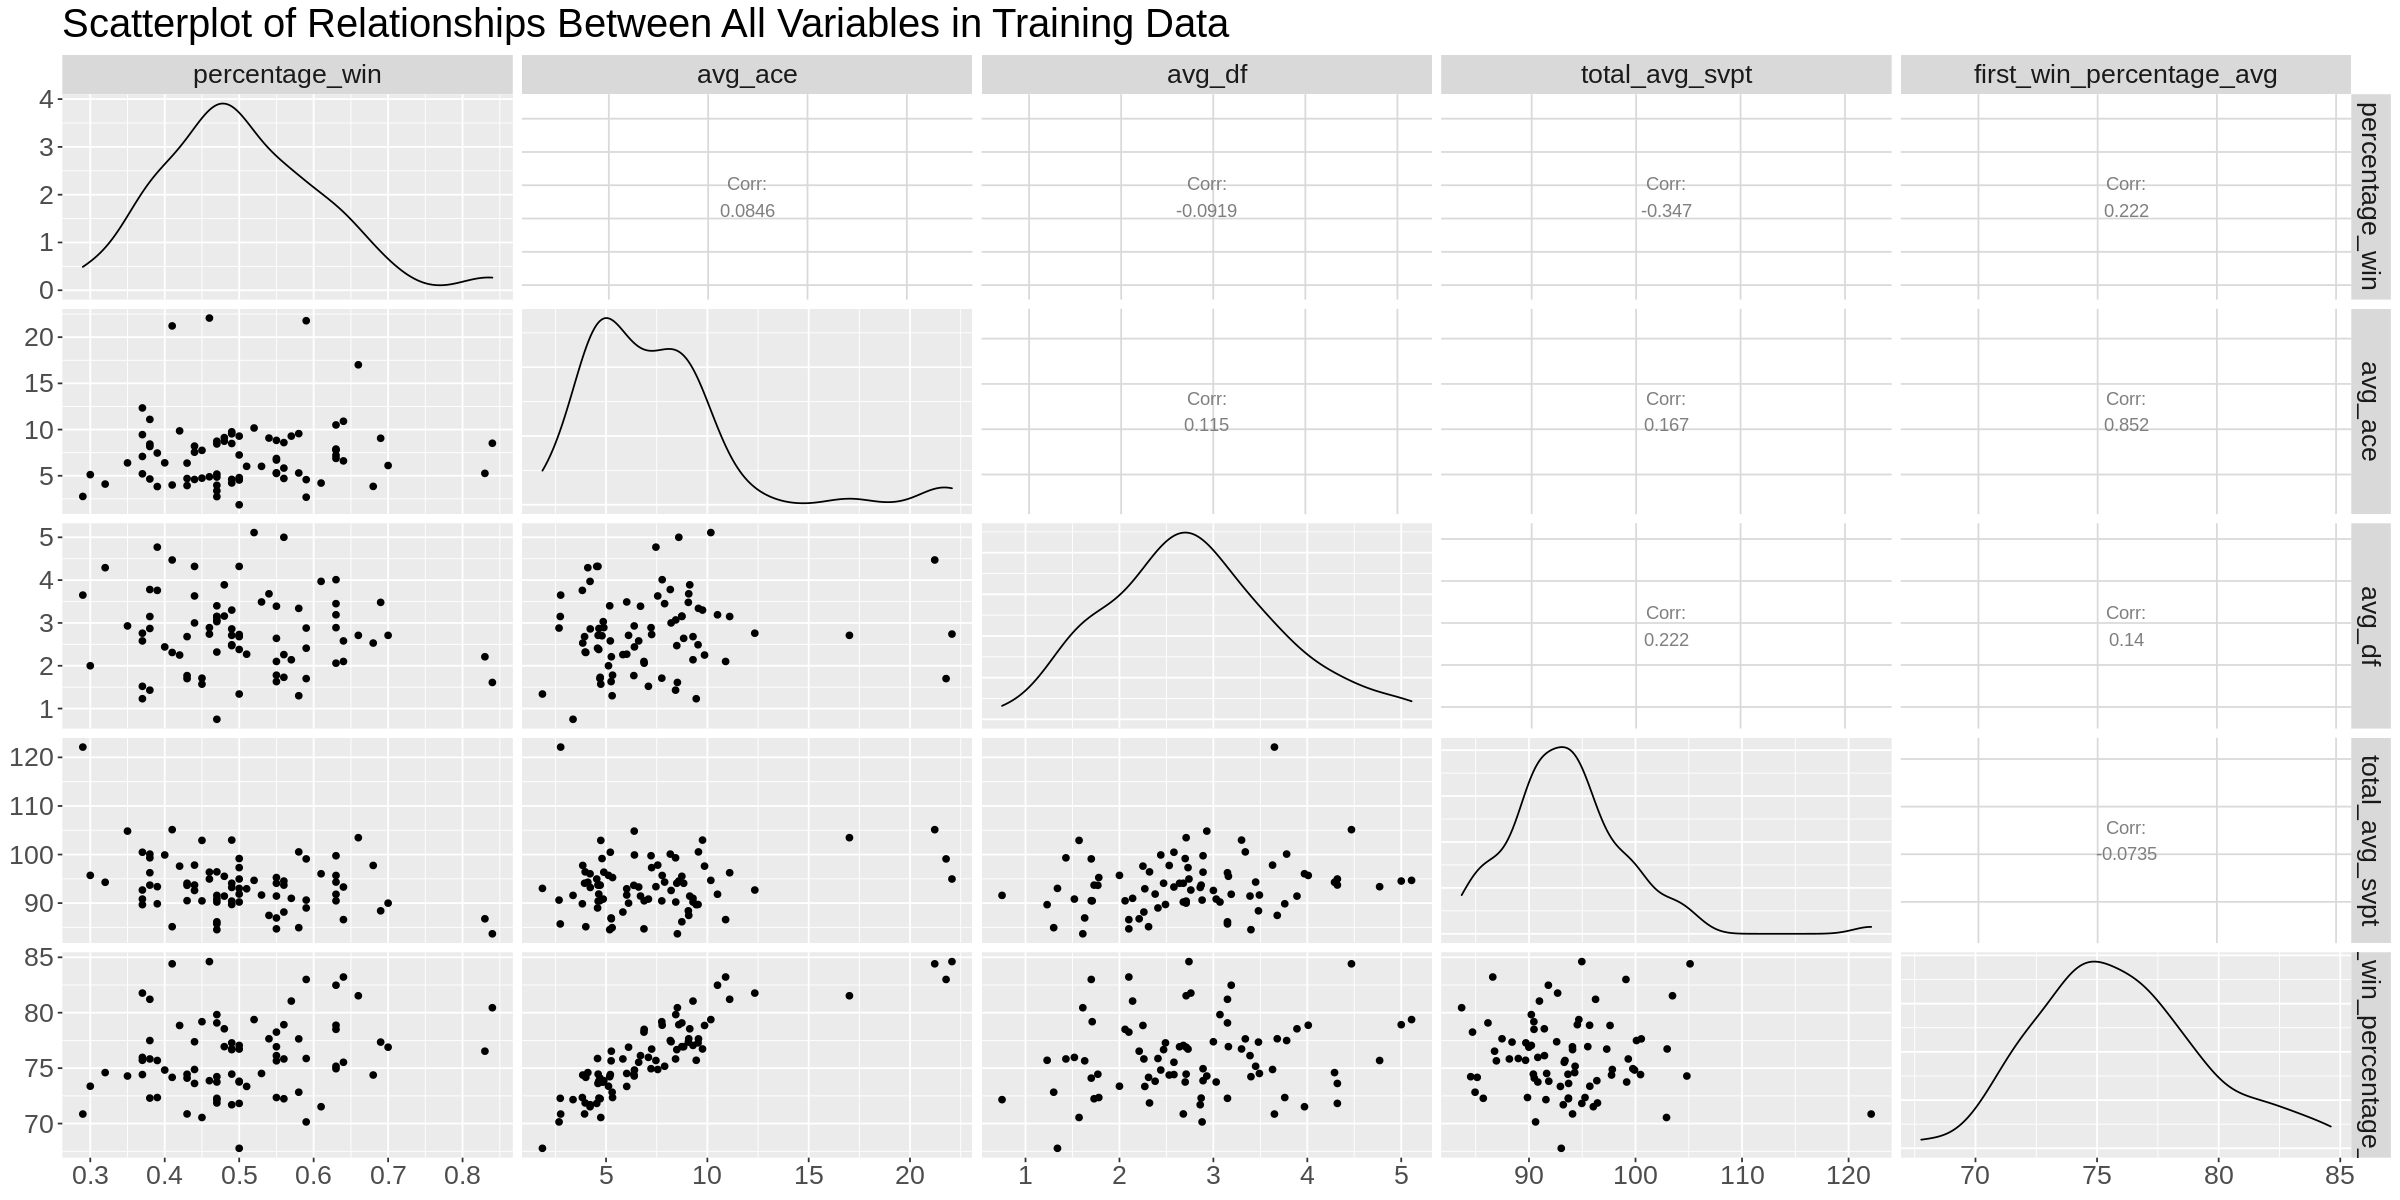

In [78]:
options(repr.plot.width = 20, repr.plot.height = 10)

relationships <- data_train %>%
    ggpairs(columns = 1:ncol(data_train), title = "Scatterplot of Relationships Between All Variables in Training Data", axisLabels = "show") +
#plotting the correlations between all variables against each other in data_train
    theme(text = element_text(size = 20))
    
relationships

### Methods

The following variables will serve as predictors to the KNN regression model to ultimately predict the percentage number of games (percentage_win) a player could win based on their serving skills:
- avg_ace
- avg_df
- total_avg_svpt
- first_win_percentage_avg

KNN regression involves creating a recipe for the model (in which the predictors are specified, scaled, and centered), cross-validating the classifier, creating a KNN regression model and workflow, applying it to the training data to select the best K value (by using the lowest RMSPE value), fitting the model using this K value on the training data, and then assessing the RMSPE of the training data when applying this classifier to it.
The classifier can then be used to make new predictions about potential players.

To visualize the results, a KNN regression line can be graphed on plots of each predictor against the predicted variable individually in order to examine the relationships between them (e.g. average percentage of successful first serves in a match against the percentage win of the winners).

### Expected Outcomes

The data analysis on "Game results for Top 500 Players from 2017-2019" is expected to predict the percentage of games a player will win based comprehensively on the variables that indicate a player's serving skills. For example, a player with high avg_df — the average number of double faults — should intuitively have a lower win ratio than one with a low avg_df.

The results of the data analysis could help companies/sponsors find good players — that is, likely to win games — by assessing their serving skill. It could also provide guidance as to how tennis players should train to maximize their number of victorious matches.

This analysis focuses on a specific element that may influence a tennis player's performance. Other potential investigations could include the relationship between a player's innate traits (e.g. height, age, etc.) and their performance, or between the latter and external factors (e.g. type of terrain).
It may also be interesting to examine the potential factors that influence the accuracy of the regression model to be created in order to better understand the relationship between serving skill and percentage victory (e.g. is it possible that the two variables have a weak/non-existent relationship?).